In [1]:
import json
import glob
import pandas as pd
import numpy as np
import os
import shutil

from PIL import Image
import matplotlib.pyplot as plt

path = './data/data-of-baselines.json'

In [2]:
#load data from the json file
with open(path) as train_file:
    data = json.load(train_file)

# Survay results:

upload Id workers and search for duplicate workers

In [3]:
raw_df_state_to_action = pd.DataFrame.from_dict(data['humanModel'], orient='index')
raw_df_state_to_action = raw_df_state_to_action.drop(0, axis=1)

participants_df = pd.DataFrame.from_dict(data['all-games'], orient='index')

path = 'data/workers' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    fromOne = pd.read_csv(filename, index_col=None, header=0)
    fromOne['filename'] = filename
    li.append(fromOne)

workers = pd.concat(li, axis=0, ignore_index=True)
workers = workers.set_index('Answer.surveycode')
workers.index = workers.index.map(lambda code: '-' + code[:-3])
# print(workers.index[workers.index.duplicated()])
workers = workers[~workers.index.duplicated(keep='first')]
participants_df['WorkerId'] = workers['WorkerId']
participants_df = participants_df.dropna(subset = ['WorkerId'])
participants_df.head()

,behavior,additional_comments,birth_year,collaborative_value,computer_score,computer_value,education,gender,human_score,predictable_value,selfishly_value,wisely_value,WorkerId
-N2gl9wHXMJoXRg5OyiP,follow_stag,,1980,4,31.000,7,BA,male,36.000,6,1,4,A6Y7SZU9L301W
-N2gnbwu9gs6PgpScg-B,follow_stag,,1994,7,19.000,7,BA,female,36.000,4,1,4,A3RHJEMZ4EGY2U
-N2gpqCiV6iClR2iJfDD,follow_stag,good,1975,5,8.000,4,Master's degree,male,13.000,6,4,5,APIUR4WD44BQ1
-N2gzRD6MoUAWRj3PaOV,follow_stag,no,1988,5,7.000,1,BA,male,8.000,6,6,5,AJ9IY4IHOGB8
-N2h6FFFrGGqFAUIRi6W,follow_stag,good,1988,6,0.000,6,BA,female,6.000,6,6,6,A2JPO11US5Q4H4


In [4]:
participants_df.columns

Index(['behavior', 'additional_comments', 'birth_year', 'collaborative_value',
       'computer_score', 'computer_value', 'education', 'gender',
       'human_score', 'predictable_value', 'selfishly_value', 'wisely_value',
       'WorkerId'],
      dtype='object')

In [5]:
index_to_drop = participants_df[participants_df.duplicated('WorkerId', keep='first')].index
print(len(index_to_drop))

participants_df = participants_df[~participants_df.duplicated('WorkerId', keep='first')]

1


number of people that answer the survay only once:

In [6]:
len(participants_df)

100

In [7]:
# participants_df[['computer_score', 'human_score', 'behavior']].to_excel("agents_score.xlsx")

In [8]:
participants_df[['additional_comments', 'behavior']][participants_df['additional_comments'].notna()][participants_df['additional_comments'] != ""].tail()

,additional_comments,behavior
-N3uhxvCsCnmNwN-PucK,interesting,follow_stag
-N3umgI6PwHgE_vrnPx8,Thank you for the game!,follow_stag
-N3uuFquU_oj8cLxKm9S,n/a,closest
-N3vEf547tTerzaHQk0o,good,random
-N3xR5UfHcnRH5BS3meJ,This survey is good.,closest


In [9]:
participants_df.loc[: ,'human_score'] = pd.to_numeric(participants_df['human_score'], errors='coerce')
participants_df.loc[: ,'computer_score'] = pd.to_numeric(participants_df['computer_score'], errors='coerce')
participants_df.loc[: ,'collaborative_value'] = pd.to_numeric(participants_df['collaborative_value'], errors='coerce')
participants_df.loc[: ,'predictable_value'] = pd.to_numeric(participants_df['predictable_value'], errors='coerce')
participants_df.loc[: ,'selfishly_value'] = pd.to_numeric(participants_df['selfishly_value'], errors='coerce')
participants_df.loc[: ,'wisely_value'] = pd.to_numeric(participants_df['wisely_value'], errors='coerce')
participants_df.loc[: ,'computer_value'] = pd.to_numeric(participants_df['computer_value'], errors='coerce')

In [10]:
participants_df.groupby('behavior')[['computer_score', 'human_score', 'collaborative_value', 'predictable_value', 'selfishly_value', 'wisely_value', 'computer_value']].mean()

,computer_score,human_score,collaborative_value,predictable_value,selfishly_value,wisely_value,computer_value
behavior,,,,,,,
closest,26.638889,19.722222,3.527778,4.083333,4.750000,4.277778,5.583333
follow_stag,17.576923,27.807692,5.423077,5.153846,3.000000,4.807692,5.461538
random,7.000000,20.842105,3.789474,4.026316,4.210526,3.500000,5.868421


In [11]:
participants_df['behavior'].value_counts()

random         38
closest        36
follow_stag    26
Name: behavior, dtype: int64

In [12]:
participants_df['gender'].value_counts()

male      68
female    32
Name: gender, dtype: int64

In [13]:
participants_df['education'].value_counts()

BA                 64
High School        20
Master's degree    15
Ph.D                1
Name: education, dtype: int64

# View some data

In [14]:
# for row in state_df.iterrows():


In [15]:
# remove from the dataset :
raw_df_state_to_action = raw_df_state_to_action.drop(index_to_drop)
blacklist = ['-N3uwriVafH0_BPfAOAr', '-N3uSY8tzzjOFSSewL0q']
raw_df_state_to_action = raw_df_state_to_action.drop(blacklist)
raw_df_state_to_action.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, -N2gl9wHXMJoXRg5OyiP to -N3xR5UfHcnRH5BS3meJ
Columns: 168 entries, 1 to 168
dtypes: object(168)
memory usage: 136.0+ KB


In [16]:
map_size = [5,5]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def extractAction(cell):
    if cell != None:
        return int(cell['humanAction'])
    return np.nan

def extractState(cell):
    if cell == None:
        return cell
    
    if any(x > 4 for x in cell['stateCoords']):
        print('cell is not valid: ', cell)
        return
    cell = cell['stateCoords']
    r = np.zeros(map_size)
    g = np.zeros(map_size)
    b = np.zeros(map_size)
    # computer pos    
    b[cell[0], cell[1]] += 1
    # human pos
    r[cell[2], cell[3]] += 1
    # stag pos
    r[cell[4], cell[5]] += 0.8039
    g[cell[4], cell[5]] += 0.498
    b[cell[4], cell[5]] += 0.1961
    # plants pos
    for i in range(6, 12, 2):
        g[cell[i], cell[i+1]] = 1
    return NormalizeData(np.dstack((r,g,b)))
    
state_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
action_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
for col in raw_df_state_to_action:
    state_df[col] = raw_df_state_to_action[col].apply(extractState)
    action_df[col] = raw_df_state_to_action[col].apply(extractAction)

In [17]:
action_df[(action_df.count(axis=1) > 60)]

,1,2,3,4,5,6,7,8,9,10,...,159,160,161,162,163,164,165,166,167,168


In [18]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def combine_following_states(cell1, cell2):
    # # history = 0.9*history + 0.1*cell2
    # # cell = 0.9*history + cell2
    # # cell = NormalizeData(cell)
    # # return cell, history
    # r2, g2, b2 = cell2[:, :, 0], cell2[:, :, 1], cell2[:, :, 2]
    # human_pos = np.where(r2 == 1)
    # computer_pos = np.where(b2 == 1)
    # bushes_pos = np.where(g2 == 1)
    # stag_pos = np.where(r2 == 0.8039, g2 == 0.498, b2 == 0.1916)
    # new_cell = cell1 * 0.9
    # new_cell[:, :, 0][human_pos] += 1
    # new_cell[:, :, 1][bushes_pos] += 1
    # new_cell[:, :, 2][computer_pos] += 1

    # new_cell[:, :, 0][stag_pos] += 0.8039
    # new_cell[:, :, 1][stag_pos] += 0.498
    # new_cell[:, :, 2][stag_pos] += 0.1916
    # return NormalizeData(new_cell)
    return NormalizeData(cell1 * 0.9 + cell2)

new_state_df = state_df.copy()
for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
    for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
        # check if it is not the last state
        # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
        if not np.isnan(action_df.loc[idxRow, idxCol]):
            if idxCol == 1:
                continue
            else:
            # new_state_df.loc[idxRow, idxCol], history = combine_following_states(history, new_state_df.loc[idxRow, idxCol])
                new_state_df.loc[idxRow, idxCol] = combine_following_states(new_state_df.loc[idxRow, idxCol-1], new_state_df.loc[idxRow, idxCol])

# view one game

In [19]:
def rowToImage(row, col=61):
    fig = plt.figure(figsize=(80, 80))
    row_s = new_state_df.loc[row, :col]
    row_a = action_df.loc[row, :col]
    cols_i = row_a.count()
    for i in range(1, cols_i+1):
        rows = 1
        columns = cols_i
        state = row_s.at[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(state)
        plt.axis('off')
        action = row_a.at[i]
        plt.title(str(i) + " action: " + str(action), fontsize=8)

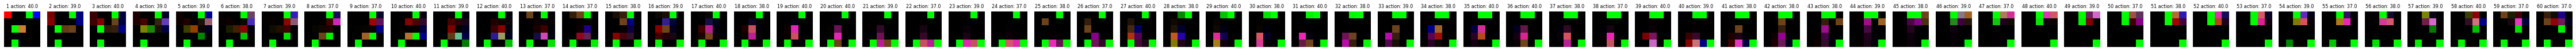

In [20]:
rowToImage('-N2gl9wHXMJoXRg5OyiP')

In [21]:
action_df[len(action_df.columns) + 1] = np.NaN
action_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,160,161,162,163,164,165,166,167,168,169
-N3v7NW69veDQNJNnpaO,40,40,39,39,38,38,40,40,37,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N3vEf547tTerzaHQk0o,40,39,37,40,39,40,39,39,40,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N3vP08kpF1JCjMg8zi0,40,39,39,40,37,38,37,40,40,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N3vS2etXaI8llgn0qrz,40,39,39,40,40,40,39,38,39,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N3xR5UfHcnRH5BS3meJ,39,37,39,40,38,39,37,37,40,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Make Dataset

In [22]:
# dir_path = './data/humanModel/dataset_v0.csv'
# if os.path.exists(dir_path):
#   os.remove(dir_path)

# rows = [
# ["code", "step", "computer_x", "computer_y", "human_x", "human_y", "stag_x", "stag_y", "shrub1_x", "shrub1_y", "shrub2_x", "shrub2_y", "shrub3_x", "shrub3_y", "human_action"] #, "computer_action", "stag_action"]
# ]
# counter = 0
# for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
#     for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
#         # check if it is not the last state
#         # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
#         if not np.isnan(action_df.loc[idxRow, idxCol+1]):
#             row = flatten([[idxRow, idxCol], flatten(state), [int(action)]])
#             if counter % 500 == 0:
#                 # print every 500 saved images
#                 print(row)
#             counter += 1
#             rows.append(row)
#         else:
#             break
# print(f'{counter} rows have been saved')
# np.savetxt(dir_path, 
#            rows,
#            delimiter =", ", 
#            fmt ='% s')
dir_path = './data/humanModel/dataset_v0'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
os.mkdir(dir_path)
for action in ['37','38','39','40']:
    os.mkdir(dir_path+'/'+action)

counter = 0
for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
    for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
        # check if it is not the last state
        if not np.isnan(action_df.loc[idxRow, idxCol]):
            im = Image.fromarray((state * 255).astype(np.uint8))
            path = f'data/humanModel/dataset_v0/{int(action)}/{idxRow}_{idxCol}.png'
            if counter % 500 == 0:
                # print every 500 saved images
                print(f'{idxRow}_{idxCol}.png saved! at action {action}')
            counter += 1
            im.save(path)
        else:
            break
#         print (state, action, idxCol, idxRow)
print(f'{counter} images have been saved')

-N2gl9wHXMJoXRg5OyiP_1.png saved! at action 40.0
-N2r2GA0RQq64JcONsNv_32.png saved! at action 38.0
-N2r6pAEKaMLbxso_Nom_52.png saved! at action 37.0
-N2rFArf2KoY-4fAoyac_12.png saved! at action 38.0
-N2rKx8TZSF-xCFJ9jsW_32.png saved! at action 40.0
-N3uSFmsGH9QoeLMn2Sp_52.png saved! at action 37.0
-N3uSv0t5MMoHiSk9mV9_12.png saved! at action 40.0
-N3uVZfhztA2fjkrdF8r_32.png saved! at action 37.0
-N3uZDn7XlXMi7TiSV6w_20.png saved! at action 40.0
-N3ufEGQtV1mLdaLJvG0_20.png saved! at action 38.0
-N3uk5j81irIpDQsd5rk_40.png saved! at action 38.0
-N3umvTpwkm2rIlM7PG__60.png saved! at action 38.0
-N3vS2etXaI8llgn0qrz_20.png saved! at action 38.0
6101 images have been saved
